<a href="https://colab.research.google.com/github/santiagorg2401/tensorflow_course_exercises/blob/main/06_NLP_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Natural Language Processing with TensorFlow.

## Solve importations.

In [3]:
import io
import random
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras import layers
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import TextVectorization
from sklearn.feature_extraction.text import TfidfVectorizer
from HelperFunctions import ImportHelperFunctions as IHF
from HelperFunctions import ModelHelperFunctions as MHF


physical_devices = tf.config.list_physical_devices('GPU')
print(f"TensorFlow version: {tf.__version__}")
print(f"Physical GPUs: {physical_devices}")

TensorFlow version: 2.12.0
Physical GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Load-in data.

In [4]:
ihf = IHF()
try:
  ihf.unzip_data("nlp_getting_started.zip")
except:
  !wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
  ihf.unzip_data("nlp_getting_started.zip")

SEED = 42
TFBOARD_DIR = "tensorboard_logs/06_NLP-TF"
CHECKPOINT_DIR = "checkpoints/06_NLP-TF"
MODEL_DIR = "models/06_NLP-TF"

# Read data.
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# Shuffle data.
train_df_shuffled = train_df.sample(frac=1, random_state=SEED)

# Use train_test_split to split training data into training and validation sets.
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1,
                                                                            random_state=SEED)
# Check first 10 samples.
print(train_sentences[:10],  "\n", train_labels[:10], "\n")

# Visualize.
print(train_df_shuffled.target.value_counts())
train_df_shuffled.head()

['@mogacola @zamtriossu i screamed after hitting tweet'
 'Imagine getting flattened by Kurt Zouma'
 '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....'
 "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet"
 'Somehow find you and I collide http://t.co/Ee8RpOahPk'
 '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao'
 'destroy the free fandom honestly'
 'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE'
 '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.'
 'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'] 
 [0 0 1 0 0 1 1 0 1 1] 

target
0    4342
1    3271
Name: count, dtype: int64


,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [5]:
random_index = random.randint(0, len(train_df) - 5)
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 1 (real disaster)
Text:
Avalanche City - Sunset http://t.co/48h3tLvLXr #nowplay #listen #radio

----

Target: 0 (not real disaster)
Text:
The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'

----

Target: 0 (not real disaster)
Text:
When high fashion and food collide: Gucci has chosen one of ShanghaiÛªs most popular commercial avenue... http://t.co/MkRxQZeHmY #fashion

----

Target: 0 (not real disaster)
Text:
@BoomerangTime @RSKarim1 @sopameer @wattashit3 Appears to already be arriving in Ridah in body bags.

----

Target: 1 (real disaster)
Text:
Police Officer Wounded Suspect Dead After Exchanging Shots: Richmond police officer wounded suspect killed after exchange of gunfire

----



## Tokenization & embedding.
* **Tokenization**: direct maping from a token (int or one-hot encoded vector) to number but it becomes huge as more different words are used.
* **Embedding**: richer representations or relationships between tokens, can be learned and the length set.

### Tokenization.

In [6]:
text_vectorizer = TextVectorization(max_tokens=None,
                                    standardize="lower_and_strip_punctuation",
                                    split="whitespace",
                                    ngrams=None,
                                    output_mode="int",
                                    output_sequence_length=None)

# Find the average number of tokens (words) in the training tweets.
avg_length = round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))
max_vocab_length = int(1e04)

print("Average number of tokens: ", avg_length)

# Setup text vectorization.
text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=avg_length)

# Fit the text vectorizer.
text_vectorizer.adapt(train_sentences)

# Visualize a tokenized sample.
print(f"""Original text: {[train_sentences[0]]}
Tokenized text: {text_vectorizer([train_sentences[0]])}""")

# Get unique words in the vocabulary.
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5]
bottom_5_words = words_in_vocab[-5:]

print(
f"""Number of words in vocab: {len(words_in_vocab)}
5 most common words: {top_5_words}
5 least common words: {bottom_5_words}""")

2023-05-07 10:40:27.428529: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-07 10:40:27.428707: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-07 10:40:27.428811: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Average number of tokens:  15
Original text: ['@mogacola @zamtriossu i screamed after hitting tweet']
Tokenized text: [[   1 6507    8  387   43 2956  978    0    0    0    0    0    0    0
     0]]
Number of words in vocab: 10000
5 most common words: ['', '[UNK]', 'the', 'a', 'in']
5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


### Embedding.

In [7]:
embedding = layers.Embedding(input_dim=max_vocab_length,
                             output_dim=128,
                             input_length=avg_length)
embedding

random_sentence = random.choice(train_sentences)
sample_embed = embedding(text_vectorizer([random_sentence]))

print(
f"""
Layer: {embedding}
Original text: {random_sentence}
Embedded version: {sample_embed}
"""
)

# Check out a single token's embedding.
sample_embed[0][0], sample_embed[0][0].shape, random_sentence  


Layer: <keras.layers.core.embedding.Embedding object at 0x7f8e79526df0>
Original text: Still and Box alarm for the train derailment at 61st and Calumet struck out on the orders of 2-1-21. #ChicagoScanner
Embedded version: [[[ 0.04534092  0.02674821  0.01293662 ... -0.00528891 -0.0416885
   -0.03942329]
  [-0.03939792  0.02684433  0.02454657 ... -0.00125404 -0.03466908
    0.01713785]
  [ 0.04842922  0.02447596  0.03110139 ... -0.01956471 -0.02268994
   -0.02330803]
  ...
  [-0.01090565  0.0251089   0.00144016 ... -0.01246731 -0.00670413
    0.026219  ]
  [-0.00461984 -0.00751873  0.01282683 ...  0.03926111 -0.00612979
    0.04217473]
  [-0.01999153 -0.04758443 -0.02774022 ... -0.03378743  0.02473665
    0.02952315]]]



(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([ 0.04534092,  0.02674821,  0.01293662, -0.02862593, -0.00704028,
        -0.00472082,  0.02391025,  0.03744438, -0.02538321, -0.00035964,
        -0.03976525, -0.02630936,  0.01489941,  0.02505232,  0.03257069,
         0.0234059 ,  0.00326451, -0.03439367, -0.02337531, -0.01804934,
        -0.01820047,  0.00266695, -0.00677122, -0.01785729, -0.00736827,
         0.04108951, -0.02599086,  0.01595012, -0.02455033, -0.00559809,
        -0.00214465, -0.03897529,  0.03713663,  0.04186927,  0.00501757,
         0.02082391, -0.04851439, -0.01742756,  0.03177347, -0.02125529,
        -0.00977296, -0.03936738,  0.03375808, -0.02762404, -0.00432309,
        -0.04470897, -0.00101014, -0.00315873, -0.00745177, -0.00962852,
        -0.02419804,  0.03033498, -0.02777789,  0.03698554, -0.03176557,
         0.0390427 , -0.00444063,  0.02311714,  0.02621219,  0.02866112,
         0.03215918,  0.02417893, -0.01054933, -0.0343341 ,  0.01157869,
  

## `model_0`: Naive Bayes Text Classifier (non-DL baseline).

In [8]:
# Create tokenization and modelling pipeline.
model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()),   # Converts words to numbers.
    ("clf", MultinomialNB())          # Model the text.
])

# Fit the pipeline to the training data.
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [9]:
# Evaluate the model.
model_0_eval = model_0.score(val_sentences, val_labels)
print(f"model_0 accuracy: {model_0_eval*100:.2f}%")

model_0 accuracy: 79.27%


In [10]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy" : model_accuracy,
                   "precision" : model_precision,
                   "recall" : model_recall,
                   "f1" : model_f1}
  return model_results


In [11]:
model_0_preds = model_0.predict(val_sentences)
model_0_results = calculate_results(val_labels,
                                    model_0_preds)
model_0_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

## `model_1`: A simple dense model.

### 1. Create model.

In [12]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model_1 = tf.keras.Model(inputs, outputs, name="model_1")
model_1_MHF = MHF(img_shape=None, model=model_1, class_names=[])

model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_1_history = model_1.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[model_1_MHF.create_tensorboard_callback(TFBOARD_DIR, model_1.name)])
model_1.summary()

Saving TensorBoard log files to: tensorboard_logs/06_NLP-TF/model_1/20230507-104028
Epoch 1/5


2023-05-07 10:40:29.443360: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-05-07 10:40:29.443669: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f8b54483240 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-07 10:40:29.443679: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2023-05-07 10:40:29.446250: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-05-07 10:40:29.559429: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-05-07 10:40:29.645448: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifeti

215/215 [==============================] - 11s 45ms/step - loss: 0.6104 - accuracy: 0.6927 - val_loss: 0.5382 - val_accuracy: 0.7428
Epoch 2/5
215/215 [==============================] - 2s 8ms/step - loss: 0.4405 - accuracy: 0.8183 - val_loss: 0.4674 - val_accuracy: 0.7887
Epoch 3/5
215/215 [==============================] - 2s 7ms/step - loss: 0.3464 - accuracy: 0.8605 - val_loss: 0.4595 - val_accuracy: 0.7940
Epoch 4/5
215/215 [==============================] - 1s 3ms/step - loss: 0.2837 - accuracy: 0.8908 - val_loss: 0.4659 - val_accuracy: 0.7848
Epoch 5/5
215/215 [==============================] - 1s 5ms/step - loss: 0.2377 - accuracy: 0.9121 - val_loss: 0.4788 - val_accuracy: 0.7822
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 

### 2. Evaluate model.

In [13]:
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 1ms/step - loss: 0.4788 - accuracy: 0.7822


[0.47878003120422363, 0.7821522355079651]

In [41]:
model_1_probs = model_1.predict(val_sentences)
model_1_preds = tf.squeeze(tf.round(model_1_probs))
model_1_results = calculate_results(val_labels,
                                    model_1_preds)
model_1_results

24/24 [==============================] - 0s 853us/step


{'accuracy': 78.87139107611549,
 'precision': 0.7948464726843409,
 'recall': 0.7887139107611548,
 'f1': 0.7853694687698636}

## Visualize learned embeddings.

In [15]:
# Create embedding files.
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

weights = model_1.get_layer("embedding").get_weights()[0]
vocab = text_vectorizer.get_vocabulary()

for index, word in enumerate(vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

## `model_2`: LSTM-RNN

### 1. Create model.

In [16]:
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.LSTM(64, return_sequences=True)(x)
x = layers.LSTM(64)(x)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model_2 = tf.keras.Model(inputs, outputs, name="model_2")
model_2_MHF = MHF(img_shape=None, model=model_2, class_names=[])

model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_2_history = model_2.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[model_2_MHF.create_tensorboard_callback(TFBOARD_DIR, model_2.name)])
model_2.summary()

Saving TensorBoard log files to: tensorboard_logs/06_NLP-TF/model_2/20230507-104045
Epoch 1/5


2023-05-07 10:40:45.545525: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-07 10:40:45.546280: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-07 10:40:45.547083: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

215/215 [==============================] - ETA: 0s - loss: 0.2189 - accuracy: 0.9237

2023-05-07 10:40:55.275130: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-07 10:40:55.276093: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-07 10:40:55.276721: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

215/215 [==============================] - 10s 36ms/step - loss: 0.2189 - accuracy: 0.9237 - val_loss: 0.6111 - val_accuracy: 0.7808
Epoch 2/5
215/215 [==============================] - 2s 8ms/step - loss: 0.1578 - accuracy: 0.9410 - val_loss: 0.6284 - val_accuracy: 0.7795
Epoch 3/5
215/215 [==============================] - 1s 6ms/step - loss: 0.1259 - accuracy: 0.9511 - val_loss: 0.7637 - val_accuracy: 0.7848
Epoch 4/5
215/215 [==============================] - 2s 7ms/step - loss: 0.1096 - accuracy: 0.9575 - val_loss: 0.8566 - val_accuracy: 0.7835
Epoch 5/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0856 - accuracy: 0.9661 - val_loss: 1.0673 - val_accuracy: 0.7743
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 

### 2. Evaluate model.

In [44]:
model_2_probs = model_2.predict(val_sentences)
model_2_preds = tf.squeeze(tf.round(model_2_probs))
model_2_results = calculate_results(val_labels,
                                    model_2_preds)
model_2_results

24/24 [==============================] - 0s 2ms/step


{'accuracy': 78.08398950131233,
 'precision': 0.7880725932219085,
 'recall': 0.7808398950131233,
 'f1': 0.7768781518005669}

## `model_3` GRU-RNN

### 1. Create model.

In [18]:
inputs = layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64, return_sequences=True)(x)
x = layers.LSTM(42, return_sequences=True)(x)
x = layers.GRU(99)(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model_3 = tf.keras.Model(inputs, outputs, name="model_3")
model_3_MHF = MHF(img_shape=None, model=model_3, class_names=[])

model_3.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

model_3_history = model_3.fit(x=val_sentences,
                              y=val_labels,
                              epochs=5,
                              callbacks=[model_3_MHF.create_tensorboard_callback(TFBOARD_DIR, model_3.name)])
model_3.summary()

2023-05-07 10:41:01.930604: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-07 10:41:01.931611: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-07 10:41:01.932223: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Saving TensorBoard log files to: tensorboard_logs/06_NLP-TF/model_3/20230507-104102
Epoch 1/5


2023-05-07 10:41:02.148669: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-07 10:41:02.149594: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-07 10:41:02.150202: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

24/24 [==============================] - 5s 87ms/step - loss: 0.5492 - accuracy: 0.7572
Epoch 2/5
24/24 [==============================] - 2s 74ms/step - loss: 0.4433 - accuracy: 0.7966
Epoch 3/5
24/24 [==============================] - 1s 53ms/step - loss: 0.3823 - accuracy: 0.8320
Epoch 4/5
24/24 [==============================] - 1s 29ms/step - loss: 0.2203 - accuracy: 0.9213
Epoch 5/5
24/24 [==============================] - 1s 29ms/step - loss: 0.0931 - accuracy: 0.9619
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 1

### 2. Evaluate model.

In [47]:
model_3_probs = model_3.predict(val_sentences)
model_3_preds = tf.squeeze(tf.round(model_3_probs))
model_3_results = calculate_results(val_labels, 
                                    model_3_preds)
model_3_results

24/24 [==============================] - 0s 2ms/step


{'accuracy': 98.4251968503937,
 'precision': 0.9843200586622902,
 'recall': 0.984251968503937,
 'f1': 0.9842587395022224}

## `model_4` Bidirectional-LSTM RNN
Usually RNNs go from left to reight, just like a human normally reads, but bidirectionals can go both ways.

### 1. Create model.

In [20]:
# Build a bidirectional RNN from TensorFloe
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
# x = layers.Bidirectional(layers.GRU(64))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model_4 = tf.keras.Model(inputs, outputs, name="model_4")
model_4_MHF = MHF(img_shape=None, model=model_4, class_names=[])

model_4.compile(loss = "binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[model_4_MHF.create_tensorboard_callback(TFBOARD_DIR, model_4.name)])
model_4.summary()

Saving TensorBoard log files to: tensorboard_logs/06_NLP-TF/model_4/20230507-104112
Epoch 1/5


2023-05-07 10:41:12.029395: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-07 10:41:12.030373: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-07 10:41:12.031053: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

215/215 [==============================] - ETA: 0s - loss: 0.1336 - accuracy: 0.9596

2023-05-07 10:41:20.899490: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-07 10:41:20.900527: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-07 10:41:20.901180: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

215/215 [==============================] - 9s 32ms/step - loss: 0.1336 - accuracy: 0.9596 - val_loss: 0.7098 - val_accuracy: 0.7808
Epoch 2/5
215/215 [==============================] - 2s 9ms/step - loss: 0.0772 - accuracy: 0.9702 - val_loss: 0.9002 - val_accuracy: 0.7808
Epoch 3/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0614 - accuracy: 0.9740 - val_loss: 0.9515 - val_accuracy: 0.7822
Epoch 4/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0553 - accuracy: 0.9759 - val_loss: 1.0619 - val_accuracy: 0.7795
Epoch 5/5
215/215 [==============================] - 1s 7ms/step - loss: 0.0476 - accuracy: 0.9791 - val_loss: 1.1418 - val_accuracy: 0.7664
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 

### 2. Evaluate model.

In [49]:
model_4_probs = model_4.predict(val_sentences)
model_4_preds = tf.squeeze(tf.round(model_4_probs))
model_4_results = calculate_results(val_labels, 
                                    model_4_preds)
model_4_results

24/24 [==============================] - 0s 1ms/step


{'accuracy': 75.45931758530183,
 'precision': 0.7561422948066032,
 'recall': 0.7545931758530183,
 'f1': 0.7521560571557802}

## `model_5` 1D Conv NN

### 1. Create model.

In [22]:
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=64,
                  kernel_size=5,
                  strides=1,
                  activation="relu",
                  padding="valid")(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1, activation = "sigmoid")(x)

model_5 = tf.keras.Model(inputs, outputs, name="model_5")
model_5_MHF = MHF(img_shape=None, model=model_5, class_names=[])

model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[model_5_MHF.create_tensorboard_callback(TFBOARD_DIR, model_5.name)])

model_5.summary()

Saving TensorBoard log files to: tensorboard_logs/06_NLP-TF/model_5/20230507-104128
Epoch 1/5
215/215 [==============================] - 9s 35ms/step - loss: 0.1400 - accuracy: 0.9527 - val_loss: 0.7429 - val_accuracy: 0.7861
Epoch 2/5
215/215 [==============================] - 1s 7ms/step - loss: 0.0864 - accuracy: 0.9670 - val_loss: 0.9208 - val_accuracy: 0.7690
Epoch 3/5
215/215 [==============================] - 1s 7ms/step - loss: 0.0692 - accuracy: 0.9737 - val_loss: 0.9974 - val_accuracy: 0.7756
Epoch 4/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0604 - accuracy: 0.9761 - val_loss: 1.0651 - val_accuracy: 0.7703
Epoch 5/5
215/215 [==============================] - 1s 3ms/step - loss: 0.0538 - accuracy: 0.9793 - val_loss: 1.1269 - val_accuracy: 0.7690
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0     

### 2. Evaluate model.

In [53]:
model_5_probs = model_5.predict(val_sentences)
model_5_preds = tf.squeeze(tf.round(model_5_probs))
model_5_results = calculate_results(val_labels, 
                                    model_5_preds)
model_5_results

24/24 [==============================] - 0s 962us/step


{'accuracy': 76.9028871391076,
 'precision': 0.7701356893081864,
 'recall': 0.7690288713910761,
 'f1': 0.7671875324347506}

## `model_6` Pretrained TFHub sequence encoder.

### 1. Create model.

In [24]:
# Test pretrained model.
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed_samples = embed(["Hello there USE."])
print(embed_samples[0][:50])

2023-05-07 10:41:44.402608: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype string
	 [[{{node inputs}}]]


tf.Tensor(
[-0.02418445 -0.02220184 -0.00158845 -0.03338125  0.08570456  0.00207093
  0.03879892 -0.0144149   0.07444516  0.0707159   0.08392473 -0.0169475
 -0.08787849  0.02843234  0.05575396  0.00678472  0.00551841 -0.03560572
 -0.0022664  -0.08600483 -0.00358888  0.0139154  -0.0220024   0.05637324
 -0.07096075  0.01967159  0.0809836  -0.05455308  0.00768155 -0.0115044
  0.04672185 -0.00507139  0.02946875 -0.01188271 -0.0721555   0.06095188
 -0.02794952 -0.00958578  0.00836211 -0.02799833  0.01657134  0.01808586
  0.03580733 -0.02028758 -0.0031242   0.0513802  -0.03051076  0.01224177
  0.01014554 -0.01685438], shape=(50,), dtype=float32)


In [25]:
# Create model.
sequence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", 
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name="USE")

model_6 = tf.keras.Sequential([
    sequence_encoder_layer,
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid")
], name="model_6")

model_6_MHF = MHF(img_shape=None, model=model_6, class_names=[])

model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[model_6_MHF.create_tensorboard_callback(TFBOARD_DIR, model_6.name)])
model_6.summary()

Saving TensorBoard log files to: tensorboard_logs/06_NLP-TF/model_6/20230507-104147
Epoch 1/5


2023-05-07 10:41:47.697158: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype string
	 [[{{node inputs}}]]
2023-05-07 10:41:47.735686: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder' with dtype string and shape [?]
	 [[{{node Placeholder}}]]
2023-05-07 10:41:48.511448: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall' with dtype float and shape 

215/215 [==============================] - 3s 7ms/step - loss: 0.5042 - accuracy: 0.7873 - val_loss: 0.4492 - val_accuracy: 0.8005
Epoch 2/5
215/215 [==============================] - 1s 6ms/step - loss: 0.4145 - accuracy: 0.8164 - val_loss: 0.4392 - val_accuracy: 0.8097
Epoch 3/5
215/215 [==============================] - 1s 6ms/step - loss: 0.4004 - accuracy: 0.8222 - val_loss: 0.4352 - val_accuracy: 0.8110
Epoch 4/5
215/215 [==============================] - 1s 6ms/step - loss: 0.3944 - accuracy: 0.8281 - val_loss: 0.4315 - val_accuracy: 0.8123
Epoch 5/5
215/215 [==============================] - 1s 6ms/step - loss: 0.3871 - accuracy: 0.8289 - val_loss: 0.4306 - val_accuracy: 0.8058
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_7 (Dense)        

### 2. Evaluate model.

In [55]:
model_6_probs = model_6.predict(val_sentences)
model_6_preds = tf.squeeze(tf.round(model_6_probs))
model_6_results = calculate_results(val_labels, 
                                    model_6_preds)
model_6_results

24/24 [==============================] - 0s 4ms/step


{'accuracy': 80.5774278215223,
 'precision': 0.8065406579811286,
 'recall': 0.8057742782152231,
 'f1': 0.8047076421415382}

## `model_7` same as previous but on 10% of data only.

### 0. Prepare dataset.

In [27]:
# Create 10% subsets.
train_10_percent = train_df_shuffled[["text", "target"]].sample(frac=0.1, random_state=SEED)
train_sentences_10_percent = train_10_percent["text"].to_list()
train_labels_10_percent= train_10_percent["target"].to_list()
len(train_sentences_10_percent), len(train_labels_10_percent), len(train_sentences), len(train_labels)

(761, 761, 6851, 6851)

In [28]:
train_10_percent["target"].value_counts()

target
0    413
1    348
Name: count, dtype: int64

In [29]:
train_df_shuffled["target"].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

The code above ledas to data leakage because the model evaluates data taht it ahs already seen, hence it's wrong.

In [30]:
# TO avoid the issue above, we need to run.
train_10_percent = int(0.1 * len(train_sentences))
train_sentences_10_percent = train_sentences[:train_10_percent]
train_labels_10_percent = train_labels[:train_10_percent]
len(train_sentences_10_percent), len(train_labels_10_percent), len(train_sentences), len(train_labels)

(685, 685, 6851, 6851)

### 1. Create model.

In [31]:
# Create model.
sequence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", 
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name="USE")

model_7 = tf.keras.Sequential([
    sequence_encoder_layer,
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid")
], name="model_7")

model_7_MHF = MHF(img_shape=None, model=model_7, class_names=[])

model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_7_history = model_7.fit(train_sentences_10_percent,
                              train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[model_6_MHF.create_tensorboard_callback(TFBOARD_DIR, model_7.name)])
model_7.summary()

Saving TensorBoard log files to: tensorboard_logs/06_NLP-TF/model_7/20230507-104159
Epoch 1/5


2023-05-07 10:41:59.263098: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype string
	 [[{{node inputs}}]]
2023-05-07 10:41:59.302523: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder' with dtype string and shape [?]
	 [[{{node Placeholder}}]]
2023-05-07 10:41:59.828274: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall' with dtype float and shape 

22/22 [==============================] - 2s 24ms/step - loss: 0.6674 - accuracy: 0.7255 - val_loss: 0.6464 - val_accuracy: 0.7638
Epoch 2/5
22/22 [==============================] - 0s 11ms/step - loss: 0.5999 - accuracy: 0.8102 - val_loss: 0.5897 - val_accuracy: 0.7625
Epoch 3/5
22/22 [==============================] - 0s 11ms/step - loss: 0.5252 - accuracy: 0.8131 - val_loss: 0.5358 - val_accuracy: 0.7664
Epoch 4/5
22/22 [==============================] - 0s 11ms/step - loss: 0.4660 - accuracy: 0.8219 - val_loss: 0.5070 - val_accuracy: 0.7664
Epoch 5/5
22/22 [==============================] - 0s 11ms/step - loss: 0.4241 - accuracy: 0.8263 - val_loss: 0.4902 - val_accuracy: 0.7756
Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_9 (Dense)             

### 2. Evaluate model.

In [61]:
model_7_probs = model_7.predict(val_sentences)
model_7_preds = tf.squeeze(tf.round(model_7_probs))
model_7_results = calculate_results(val_labels, 
                                    model_7_preds)
model_7_results

24/24 [==============================] - 0s 4ms/step


{'accuracy': 77.55905511811024,
 'precision': 0.7767334207253159,
 'recall': 0.7755905511811023,
 'f1': 0.7738609431347062}

## Compare models.

In [63]:
# Create DataFrame.
results = pd.DataFrame({"model_0": model_0_results,
             "model_1": model_1_results,
             "model_2": model_2_results,
             "model_3": model_3_results,
             "model_4": model_4_results,
             "model_5": model_5_results,
             "model_6": model_6_results,
             "model_7": model_7_results})

results = results.transpose()

# Normalize accuracy metric.
results["accuracy"] = results["accuracy"]/100

# Sort by F1-Score
results = results.sort_values("f1", ascending=False)
results

,accuracy,precision,recall,f1
model_3,0.984252,0.984320,0.984252,0.984259
model_6,0.805774,0.806541,0.805774,0.804708
model_0,0.792651,0.811139,0.792651,0.786219
model_1,0.788714,0.794846,0.788714,0.785369
model_2,0.780840,0.788073,0.780840,0.776878
model_7,0.775591,0.776733,0.775591,0.773861
model_5,0.769029,0.770136,0.769029,0.767188
model_4,0.754593,0.756142,0.754593,0.752156


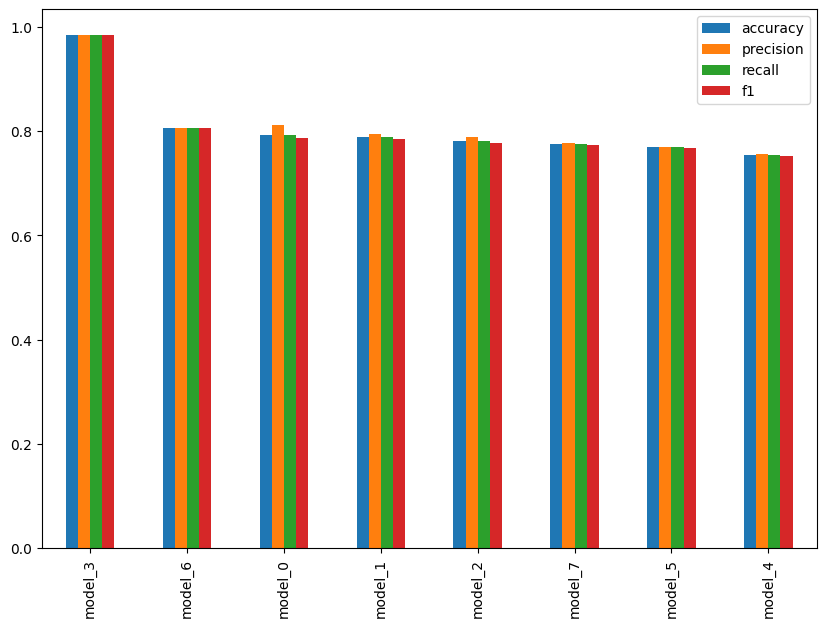

In [65]:
# Plot the results.
results.plot(kind="bar", figsize=(10,7)).legend(bbox_to_anchor=(1.0,1.0))

## Upload to TensorBoard

Command: tensorboard dev upload --logdir tensorboard_logs/06_NLP-TF/ --name "NLP Modelling Experiments." --description "Comparing multiple different types of model architectures on Kaggle Tweets dataset." --one_shot


Link: https://tensorboard.dev/experiment/hrdgWGq1SBCbAU8qtJzYAg/

## Save model.

In [66]:
model_3.save("model_3.h5")

NotImplementedError: ignored

## Finding the worst predictions.

In [68]:
val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": model_3_preds,
                       "prob": tf.squeeze(model_3_probs)})
val_df.head()

,text,target,pred,prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.065518
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.973116
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.998914
3,@camilacabello97 Internally and externally scr...,1,1.0,0.757900
4,Radiation emergency #preparedness starts with ...,1,1.0,0.988981


In [73]:
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("prob", ascending=False)
most_wrong[:10] # False positives.

,text,target,pred,prob
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.973116
188,Owner of Chicago-Area Gay Bar Admits to Arson ...,0,1.0,0.931511
399,Hollywood Movie About Trapped Miners Released ...,0,1.0,0.930086
759,FedEx will no longer transport bioterror patho...,0,1.0,0.885133
119,@freefromwolves GodsLove &amp; #thankU brother...,0,1.0,0.846459
695,A look at state actions a year after Ferguson'...,0,1.0,0.675050
630,Hollywood movie about trapped miners released ...,0,1.0,0.668749
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.604768
676,Aashiqui Actress Anu Aggarwal On Her Near-Fata...,1,0.0,0.489769
536,@DavidVonderhaar At least you were sincere ??,1,0.0,0.373917


In [74]:
most_wrong.tail() # False negatives.

,text,target,pred,prob
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.604768
676,Aashiqui Actress Anu Aggarwal On Her Near-Fata...,1,0.0,0.489769
536,@DavidVonderhaar At least you were sincere ??,1,0.0,0.373917
439,Trafford Centre film fans angry after Odeon ci...,1,0.0,0.043159
648,@brobread looks like mudslide????,1,0.0,0.017699


In [75]:
 for row in most_wrong[:10].itertuples():
   _, text, target, pred, prob = row
   print(f"Target: {target}, Pred: {pred}, Prob: {prob}")
   print(f"Text:\n{text}")
   print("----\n")

Target: 0, Pred: 1.0, Prob: 0.9731162190437317
Text:
FedEx no longer to transport bioterror germs in wake of anthrax lab mishaps http://t.co/qZQc8WWwcN via @usatoday
----

Target: 0, Pred: 1.0, Prob: 0.9315106272697449
Text:
Owner of Chicago-Area Gay Bar Admits to Arson Scheme http://t.co/0TSlQjOKvh via @theadvocatemag #LGBT
----

Target: 0, Pred: 1.0, Prob: 0.930086076259613
Text:
Hollywood Movie About Trapped Miners Released in Chile: 'The 33' Hollywood movie about trapped miners starring... http://t.co/x8moYeVjsJ
----

Target: 0, Pred: 1.0, Prob: 0.8851332664489746
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J
----

Target: 0, Pred: 1.0, Prob: 0.8464593887329102
Text:
@freefromwolves GodsLove &amp; #thankU brother Danny for RT of NEW VIDEO http://t.co/cybKsXHF7d The Coming Apocalyptic US Earthquake &amp; Tsunami
----

Target: 0, Pred: 1.0, Prob: 0.6750500202178955
Text:
A look at state actions a year after Ferguson's u

## Predictions on the test dataset.

In [76]:
test_sentences = test_df["text"].to_list()
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
  prob = tf.squeeze(model_3.predict([test_sample]))
  pred = tf.round(prob)
  print(f"Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{test_sample}\n----\n")


1/1 [==============================] - 0s 24ms/step
Pred: 0, Prob: 0.028347112238407135
Text:
Sleeping With Sirens - 2 Chord
----

1/1 [==============================] - 0s 21ms/step
Pred: 0, Prob: 0.02678947150707245
Text:
Collide Gateway students make setting up chairs and tables 10x more fun than I would've thought! ?? @collideNLC
----

1/1 [==============================] - 0s 23ms/step
Pred: 1, Prob: 0.8987088799476624
Text:
@cameron13131313 @OtooleDalton @averywelch23 @otoole1055 first of all you can't 'hit stick' shit.. Second I'm body bagging you on sight ??????
----

1/1 [==============================] - 0s 21ms/step
Pred: 1, Prob: 0.9961698651313782
Text:
#FortitudeValley unit damaged and residents evacuated after fire broke out after 7am this morning #7News http://t.co/8iZgxCeLcc
----

1/1 [==============================] - 0s 23ms/step
Pred: 1, Prob: 0.6649784445762634
Text:
[News] Saint Louis University lowers tuition for first responders http://t.co/VJRHkmHpu2
----

1/1 

## Score/speed tradeoff.

In [83]:
import time
def pred_timer(model, samples):
  start_time = time.perf_counter()
  model.predict(samples)
  end_time = time.perf_counter()
  total_time = end_time - start_time
  time_per_pred = total_time/len(samples)
  return total_time, time_per_pred

In [85]:
model_3_total_time, model_3_time_per_pred = pred_timer(model_3, val_sentences)
model_3_total_time, model_3_time_per_pred 

24/24 [==============================] - 0s 2ms/step


(0.08421542899850465, 0.00011051893569357566)